In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import imageio
import cv2
from tqdm import tqdm, tqdm_notebook
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.preprocessing.image import img_to_array
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data

In [3]:
artists = pd.read_csv('/content/drive/My Drive/SI670_Project/artists.csv')
artists.shape

(50, 8)

In [4]:
artists.head()

id  ... paintings
0   0  ...       193
1   1  ...        88
2   2  ...        70
3   3  ...        73
4   4  ...       194

[5 rows x 8 columns]

####Data Pre-processing

In [5]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
#artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


name  paintings  class_weight
8            Vincent van Gogh        877      0.192611
30                Edgar Degas        702      0.240627
13              Pablo Picasso        439      0.384784
15      Pierre-Auguste Renoir        336      0.502738
19             Albrecht Dürer        328      0.515000
46               Paul Gauguin        311      0.543151
16             Francisco Goya        291      0.580481
31                  Rembrandt        262      0.644733
20              Alfred Sisley        259      0.652201
32                     Titian        255      0.662431
22               Marc Chagall        239      0.706778
4               Rene Magritte        194      0.870722
0           Amedeo Modigliani        193      0.875233
42                  Paul Klee        188      0.898511
28              Henri Matisse        186      0.908172
45                Andy Warhol        181      0.933260
12             Mikhail Vrubel        171      0.987836
24          Sandro Botticelli        164      1.030000
26          Leonardo da Vinci        143      1.181259
14          Peter Paul Rubens        141      1.198014
5               Salvador Dali        139      1.215252
10           Hieronymus Bosch        137      1.232993
21             Pieter Bruegel        134      1.260597
27            Diego Velazquez        128      1.319687
11           Kazimir Malevich        126      1.340635
17                Frida Kahlo        120      1.407667
23          Giotto di Bondone        119      1.419496
9                Gustav Klimt        117      1.443761
47                    Raphael        109      1.549725
44                  Joan Miro        102      1.656078
7               Andrei Rublev         99      1.706263
35           Camille Pissarro         91      1.856264
6               Edouard Manet         90      1.876889
1          Vasiliy Kandinskiy         88      1.919545
18                   El Greco         87      1.941609
43              Piet Mondrian         84      2.010952
33  Henri de Toulouse-Lautrec         81      2.085432
29               Jan van Eyck         81      2.085432
3                Claude Monet         73      2.313973
2                Diego Rivera         70      2.413143
40             Henri Rousseau         70      2.413143
37               Edvard Munch         67      2.521194
36             William Turner         66      2.559394
34            Gustave Courbet         59      2.863051
25                 Caravaggio         55      3.071273
48               Michelangelo         49      3.447347
38               Paul Cezanne         47      3.594043
41             Georges Seurat         43      3.928372
39           Eugene Delacroix         31      5.449032
49            Jackson Pollock         24      7.038333

In [6]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.8752331606217617,
 1: 1.9195454545454544,
 2: 2.4131428571428573,
 3: 2.313972602739726,
 4: 0.8707216494845361,
 5: 1.215251798561151,
 6: 1.8768888888888888,
 7: 1.7062626262626264,
 8: 0.19261117445838086,
 9: 1.4437606837606838,
 10: 1.232992700729927,
 11: 1.3406349206349206,
 12: 0.9878362573099415,
 13: 0.38478359908883825,
 14: 1.1980141843971632,
 15: 0.5027380952380952,
 16: 0.5804810996563574,
 17: 1.4076666666666666,
 18: 1.941609195402299,
 19: 0.515,
 20: 0.6522007722007722,
 21: 1.2605970149253731,
 22: 0.7067782426778243,
 23: 1.4194957983193277,
 24: 1.03,
 25: 3.0712727272727274,
 26: 1.1812587412587412,
 27: 1.3196875,
 28: 0.9081720430107527,
 29: 2.0854320987654322,
 30: 0.24062678062678064,
 31: 0.6447328244274809,
 32: 0.6624313725490196,
 33: 2.0854320987654322,
 34: 2.863050847457627,
 35: 1.8562637362637362,
 36: 2.5593939393939396,
 37: 2.5211940298507463,
 38: 3.5940425531914895,
 39: 5.449032258064516,
 40: 2.4131428571428573,
 41: 3.9283720930232557,

In [7]:
# Explore images of top artists
images_dir = '/content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Vincent_van_Gogh
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Edgar_Degas
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Pablo_Picasso
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Pierre-Auguste_Renoir
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Albrecht_Dürer
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Paul_Gauguin
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Francisco_Goya
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Rembrandt
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Alfred_Sisley
Found --> /content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Titian
Found --> /content/drive/My Dri

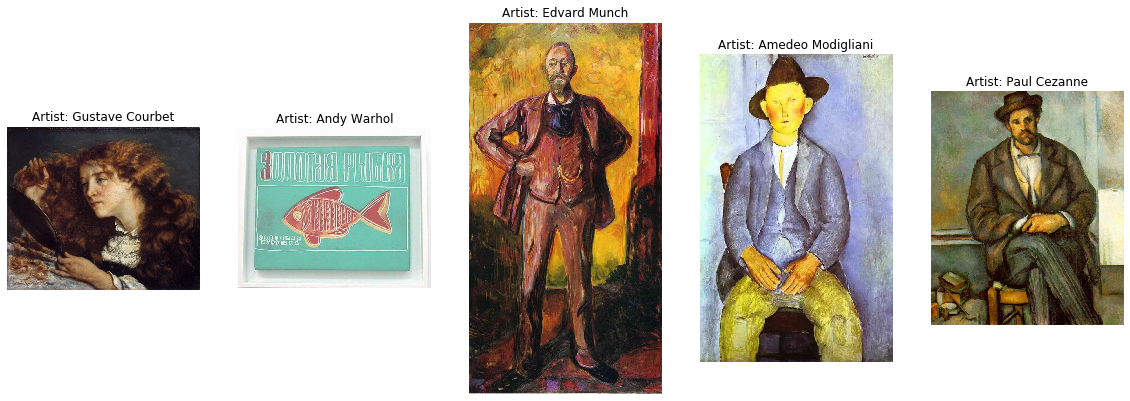

In [8]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [9]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 6780 images belonging to 50 classes.
Found 1667 images belonging to 50 classes.
Total number of batches = 423 and 104


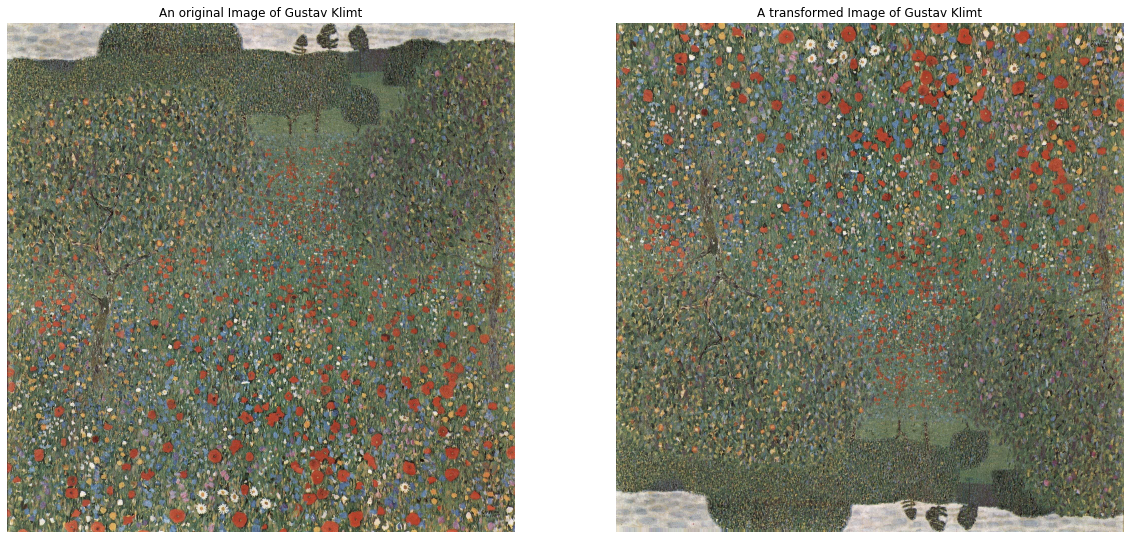

In [10]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

###Linear Classifier

In [21]:
model = Sequential()
model.add(Flatten(input_shape=(150,150,3)))
model.add(Dense(12))
model.add(Activation('softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


###ResNet Model

In [29]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94773248/94765736 [==============================] - 2s 0us/step


In [0]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [0]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10
423/423 [==============================] - 416s 983ms/step - loss: 4.9475 - acc: 0.2033 - val_loss: 3.9312 - val_acc: 0.0060
Epoch 2/10
423/423 [==============================] - 208s 491ms/step - loss: 4.2164 - acc: 0.3573 - val_loss: 3.6993 - val_acc: 0.1352
Epoch 3/10
423/423 [==============================] - 210s 496ms/step - loss: 3.8898 - acc: 0.3987 - val_loss: 2.9747 - val_acc: 0.3822
Epoch 4/10
423/423 [==============================] - 212s 502ms/step - loss: 3.5527 - acc: 0.4370 - val_loss: 2.8364 - val_acc: 0.3744
Epoch 5/10
423/423 [==============================] - 212s 501ms/step - loss: 3.2266 - acc: 0.4735 - val_loss: 2.6483 - val_acc: 0.4477
Epoch 6/10
423/423 [==============================] - 213s 504ms/step - loss: 2.9683 - acc: 0.5080 - val_loss: 2.6882 - val_acc: 0.4249
Epoch 7/10
423/423 [==============================] - 214s 506ms/step - loss: 2.6769 - acc: 0.5486 - val_loss: 2.4756 - val_acc: 0.4579
Epoch 8/10
423/423 [============================

In [0]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/50
423/423 [==============================] - 212s 502ms/step - loss: 1.7797 - acc: 0.6694 - val_loss: 2.1402 - val_acc: 0.5583
Epoch 2/50
423/423 [==============================] - 210s 496ms/step - loss: 1.8222 - acc: 0.6678 - val_loss: 2.2122 - val_acc: 0.5276
Epoch 3/50
423/423 [==============================] - 211s 498ms/step - loss: 1.8039 - acc: 0.6660 - val_loss: 2.1877 - val_acc: 0.5391
Epoch 4/50
423/423 [==============================] - 211s 499ms/step - loss: 1.8022 - acc: 0.6674 - val_loss: 2.1185 - val_acc: 0.5553
Epoch 5/50
423/423 [==============================] - 212s 500ms/step - loss: 1.8045 - acc: 0.6682 - val_loss: 2.1385 - val_acc: 0.5595
Epoch 6/50
423/423 [==============================] - 212s 501ms/step - loss: 1.7791 - acc: 0.6733 - val_loss: 2.1233 - val_acc: 0.5607
Epoch 7/50
423/423 [==============================] - 212s 500ms/step - loss: 1.7767 - acc: 0.6795 - val_loss: 2.1300 - val_acc: 0.5451
Epoch 8/50
423/423 [============================

In [0]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']

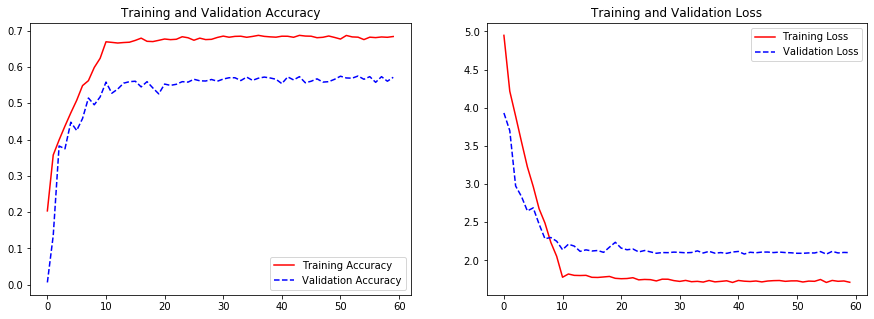

In [0]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

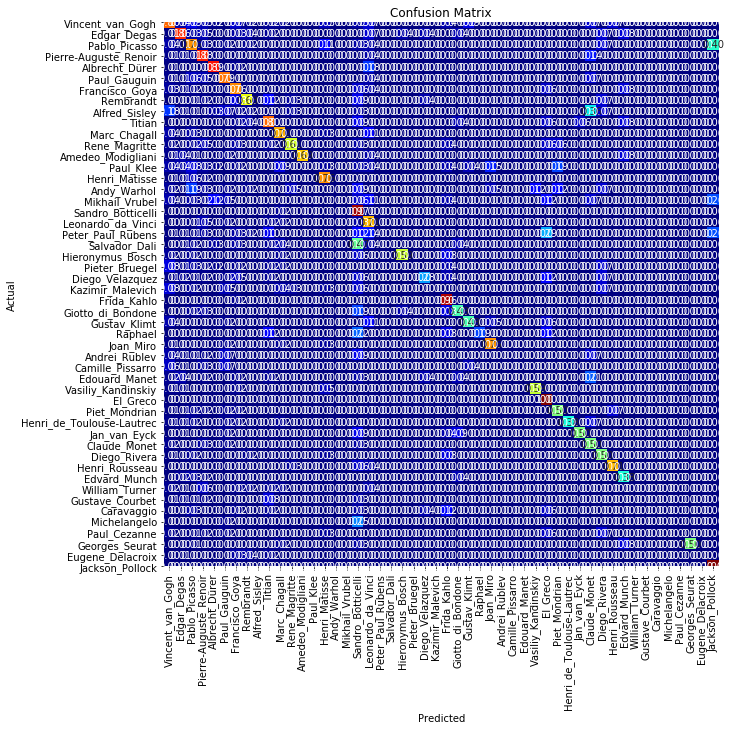

Classification Report:
                           precision    recall  f1-score   support

         Vincent_van_Gogh       0.47      0.80      0.59       170
              Edgar_Degas       0.68      0.86      0.76       140
            Pablo_Picasso       0.42      0.76      0.54        86
    Pierre-Auguste_Renoir       0.57      0.88      0.69        66
           Albrecht_Dürer       0.79      0.89      0.84        65
             Paul_Gauguin       0.61      0.79      0.69        61
           Francisco_Goya       0.57      0.76      0.65        59
                Rembrandt       0.72      0.63      0.67        52
            Alfred_Sisley       0.00      0.00      0.00        49
                   Titian       0.56      0.80      0.66        50
             Marc_Chagall       0.67      0.72      0.69        47
            Rene_Magritte       0.79      0.61      0.69        38
        Amedeo_Modigliani       1.00      0.69      0.82        36
                Paul_Klee       0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)


Predicted artist = Claude Monet
Prediction probability = 29.526618123054504 %


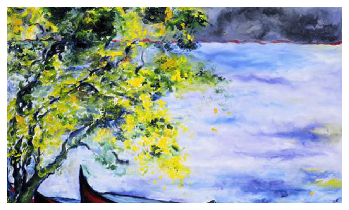

In [0]:
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = 'https://www.gpsmycity.com/img/gd/2082.jpg'

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", tick_labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

### Xception

In [0]:
# Load pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [0]:
# Add layers at the end
X = base_model.output
X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

X = tf.keras.layers.Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

output = tf.keras.layers.Dense(n_classes, activation='softmax')(X)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [24]:
history = model.fit_generator(
    generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
    epochs=10,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr],
    use_multiprocessing=True,
    workers=16,
    class_weight=class_weights
)

Epoch 1/10


KeyboardInterrupt: ignored

### MobileNet Model

In [25]:
# Load pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

17227776/17225924 [==============================] - 1s 0us/step


In [0]:
# Add layers at the end
X = base_model.output
X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

X = tf.keras.layers.Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Activation('relu')(X)

output = tf.keras.layers.Dense(n_classes, activation='softmax')(X)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [28]:
history = model.fit_generator(
    generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
    epochs=10,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr],
    use_multiprocessing=True,
    workers=16,
    class_weight=class_weights
)

Epoch 1/10


KeyboardInterrupt: ignored

### Neural Style Transfer

In [0]:
style_images = images_dir
content_images = '/content/drive/My Drive/SI670_Project/image-classification/images/images/travel and  adventure'

In [0]:
base_image_path = '/content/drive/My Drive/SI670_Project/image-classification/images/images/travel and  adventure/Places365_val_00005733.jpg'
style_image_path = '/content/drive/My Drive/SI670_Project/images.zip (Unzipped Files)/images/Pablo_Picasso/Pablo_Picasso_92.jpg'

In [0]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [0]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

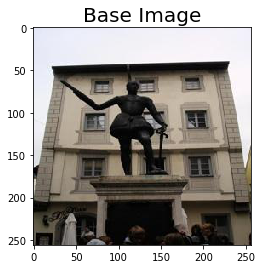

In [0]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

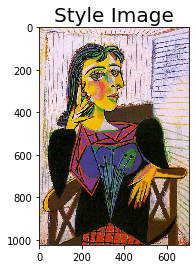

In [0]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

In [0]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [0]:
K.image_data_format()

'channels_last'

In [0]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [0]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

In [0]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '/content/drive/My Drive/SI670_Project/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')










Model loaded.


In [0]:
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 25, 512), dtype=float32)


In [0]:
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [0]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))
    

In [0]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 25, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 25, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 25, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 400, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 400, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 400, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 200, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 200, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 200, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 100, 256), 

In [0]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [0]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 400, 3) dtype=float32>]

In [0]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [0]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator = Evaluator()

In [0]:
iterations=400
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 4.4227327e+19
Start of iteration 1
Current loss value: 4.4131217e+19
Start of iteration 2
Current loss value: 4.4022348e+19
Start of iteration 3
Current loss value: 4.3916808e+19
Start of iteration 4
Current loss value: 4.3787976e+19
Start of iteration 5
Current loss value: 4.366628e+19
Start of iteration 6
Current loss value: 4.3549795e+19
Start of iteration 7
Current loss value: 4.34481e+19
Start of iteration 8
Current loss value: 4.33661e+19
Start of iteration 9
Current loss value: 4.3266763e+19
Start of iteration 10
Current loss value: 4.318071e+19
Start of iteration 11
Current loss value: 4.308833e+19
Start of iteration 12
Current loss value: 4.299841e+19
Start of iteration 13
Current loss value: 4.291175e+19
Start of iteration 14
Current loss value: 4.283234e+19
Start of iteration 15
Current loss value: 4.2737722e+19
Start of iteration 16
Current loss value: 4.2638815e+19
Start of iteration 17
Current loss value: 4.24798e+19
Start of itera

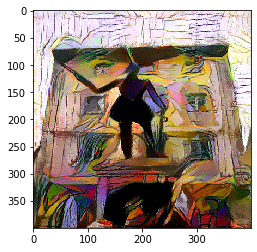

In [0]:
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

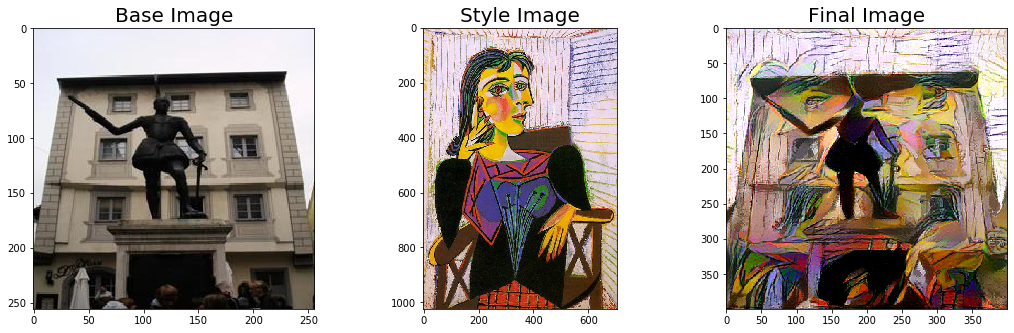

In [0]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)


plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)